Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
from sklearn.datasets import load_digits
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# Загрузка данных
digits = load_digits()

# Массив наблюдений (X) и массив истинных меток классов (y)
X = digits.data
y = digits.target

# Вывод размерности массива данных
print("Размер массива наблюдений (X):", X.shape)
print("Размер массива истинных меток классов (y):", y.shape)


Размер массива наблюдений (X): (1797, 64)
Размер массива истинных меток классов (y): (1797,)


Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

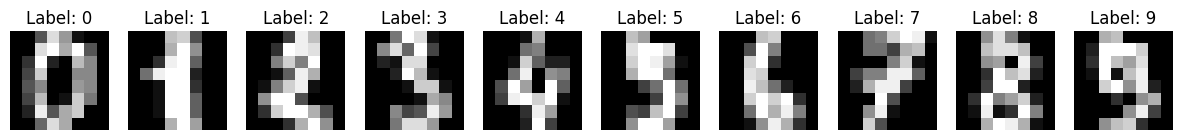

In [2]:
# Выберем несколько случайных картинок для визуализации
num_images_to_display = 10
selected_images = X[:num_images_to_display]

# Визуализация выбранных картинок
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i in range(num_images_to_display):
    axes[i].imshow(selected_images[i].reshape(8, 8), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Label: {y[i]}')

plt.show()

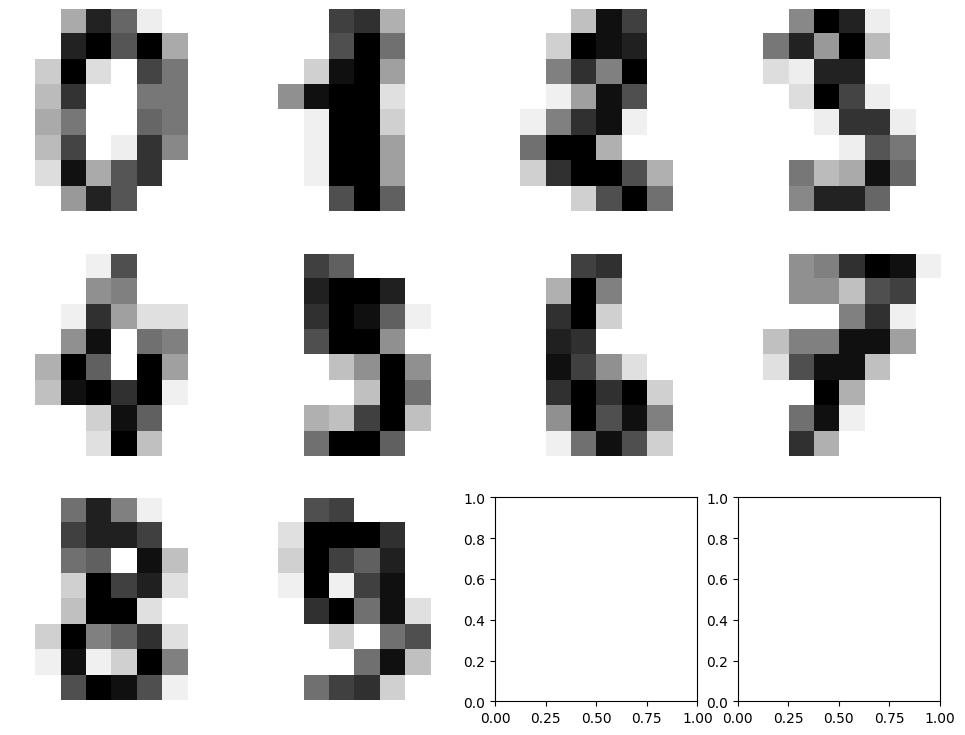

In [3]:
# Выберем первые десять картинок
num_images_to_display = 10
selected_images = X[:num_images_to_display]

# Инвертируем цвета (чтобы фон был белым, а изображения - темными)
selected_images = 16 - selected_images

# Создадим сетку 3x4
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

# Выведем каждую картинку на свой подграфик
for i in range(num_images_to_display):
    # Рассчитаем индексы строки и столбца
    row_index = i // 4
    col_index = i % 4
    
    # Отрисуем картинку
    axes[row_index, col_index].imshow(selected_images[i].reshape(8, 8), cmap='gray', interpolation='nearest')
    
    # Выключим деления на осях
    axes[row_index, col_index].axis('off')

# Отобразим картинки
plt.show()

Мне стало интересно как все эти преобразования работают изнутри и как выгялядт числа изнутри подробнее,так что я инверсировал матрицы и выводил их в виде картинок попробовав даже изобразть что-то осмысленное :

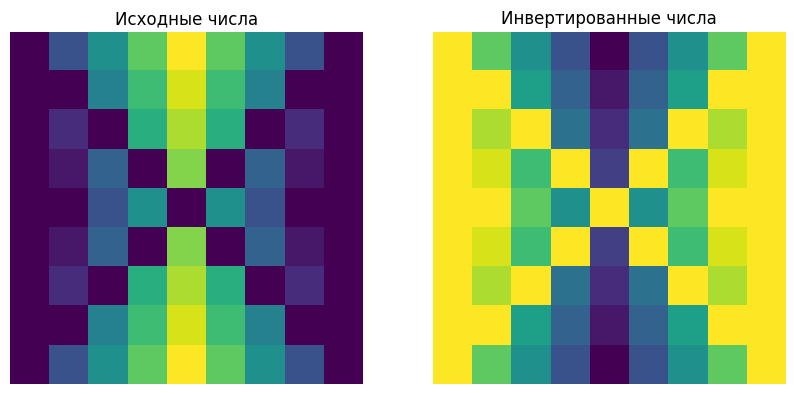

In [4]:

handwritten_numbers = np.array([
    [0, 4, 8, 12, 16, 12, 8, 4, 0],
    [0, 0, 7, 11, 15, 11, 7, 0, 0],
    [0, 2, 0, 10, 14, 10, 0, 2, 0],
    [0, 1, 5, 0, 13, 0, 5, 1, 0],
    [0, 0, 4, 8, 0, 8, 4, 0, 0],
    [0, 1, 5, 0, 13, 0, 5, 1, 0],
    [0, 2, 0, 10, 14, 10, 0, 2, 0],
    [0, 0, 7, 11, 15, 11, 7, 0, 0],
    [0, 4, 8, 12, 16, 12, 8, 4, 0]
])

# Инверсия цветов
inverted_numbers = 16 - handwritten_numbers

# Создаем два графика (два столбца)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# График с исходными числами
axes[0].imshow(handwritten_numbers, interpolation='nearest')
axes[0].set_title('Исходные числа')
axes[0].axis('off')

# График с инвертированными числами
axes[1].imshow(inverted_numbers, interpolation='nearest')
axes[1].set_title('Инвертированные числа')
axes[1].axis('off')

plt.show()

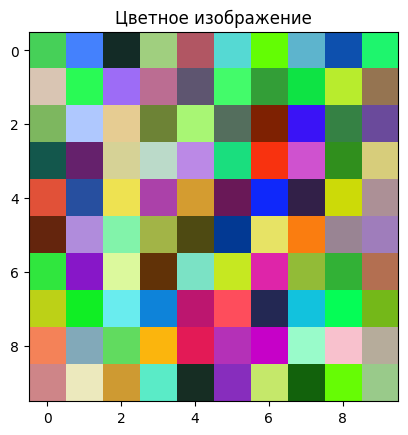

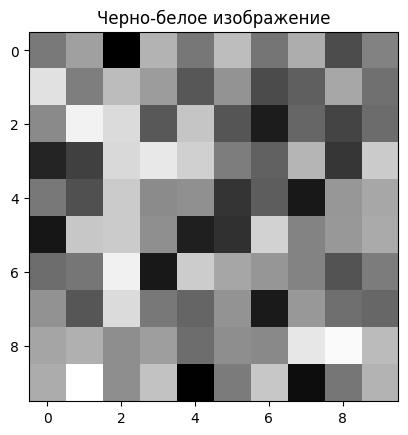

In [5]:
# Создаем цветное изображение
color_image = np.random.rand(10, 10, 3)

# Отображаем цветное изображение перед вызовом plt.gray()
plt.imshow(color_image)
plt.title('Цветное изображение')
plt.show()

# Вычисляем оттенки серого
gray_image = np.mean(color_image, axis=-1)

# Вызываем plt.gray() для переключения на черно-белый режим
plt.gray()

# Отображаем черно-белое изображение после вызова plt.gray()
plt.imshow(gray_image, cmap='gray')
plt.title('Черно-белое изображение')
plt.show()

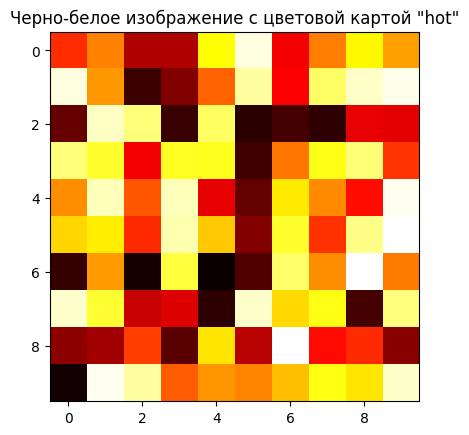

In [6]:
import matplotlib.pyplot as plt
import numpy as np

color_image = np.random.rand(10, 10, 3)


plt.gray()


plt.imshow(color_image[:, :, 0], cmap='hot')  
plt.title('Черно-белое изображение с цветовой картой "hot"')
plt.show()

по итогу своих небольших опыт единственное до чего я не до конца дошел это зачем нужен 
plt.gray() он вроде изменяет графики но сам по себе черно белым не делает,а то что я нашел значительно мне не объяснило

------------------------------------------------------------------------------------------------------------------

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [7]:


# Иерархическая кластеризация с явным указанием числа кластеров (например, 10)
hierarchical_clustering = AgglomerativeClustering(n_clusters=10)
hierarchical_labels = hierarchical_clustering.fit_predict(X)

# KMeans кластеризация с явным указанием числа кластеров (например, 10)
kmeans_clustering = KMeans(n_clusters=10, n_init=100)
kmeans_labels = kmeans_clustering.fit_predict(X)

# Выведем первые десять элементов полученных меток кластеров для каждого метода
print("Метки кластеров (Иерархическая кластеризация):", hierarchical_labels,len(hierarchical_labels),set(hierarchical_labels))
print("Метки кластеров (KMeans):", kmeans_labels,len(kmeans_labels),set(kmeans_labels))


Метки кластеров (Иерархическая кластеризация): [7 9 4 ... 4 1 4] 1797 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Метки кластеров (KMeans): [3 1 1 ... 1 2 2] 1797 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [8]:
def display_cluster_images(cluster_labels, cluster_number, num_images=5):
    # Найдем индексы изображений, принадлежащих кластеру
    cluster_indices = np.where(cluster_labels == cluster_number)[0]

    if len(cluster_indices) == 0:
        print(f"No images found for cluster {cluster_number}")
        return

    # Выберем несколько изображений из кластера
    selected_images = X[cluster_indices[:num_images]]

    # Визуализация выбранных изображений
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

    for i in range(num_images):
        axes[i].imshow(selected_images[i].reshape(8, 8), cmap='gray')
        axes[i].axis('off')

    plt.show()

# Выведем первые 5 изображений из первых 3 кластеров для иерархической кластеризации
for i in range(3):
    display_cluster_images(hierarchical_labels, i)

print("------------------------------------------")

# Выведем первые 5 изображений из первых 3 кластеров для KMeans
for i in range(3):
    display_cluster_images(kmeans_labels, i)

'def display_cluster_images(cluster_labels, cluster_number, num_images=5):\n    # Найдем индексы изображений, принадлежащих кластеру\n    cluster_indices = np.where(cluster_labels == cluster_number)[0]\n\n    if len(cluster_indices) == 0:\n        print(f"No images found for cluster {cluster_number}")\n        return\n\n    # Выберем несколько изображений из кластера\n    selected_images = X[cluster_indices[:num_images]]\n\n    # Визуализация выбранных изображений\n    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))\n\n    for i in range(num_images):\n        axes[i].imshow(selected_images[i].reshape(8, 8), cmap=\'gray\')\n        axes[i].axis(\'off\')\n\n    plt.show()\n\n# Выведем первые 5 изображений из первых 3 кластеров для иерархической кластеризации\nfor i in range(3):\n    display_cluster_images(hierarchical_labels, i)\n\nprint("------------------------------------------")\n\n# Выведем первые 5 изображений из первых 3 кластеров для KMeans\nfor i in range(3):\n    displ

------------------------------------------------------------------------------------------------------------------

Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

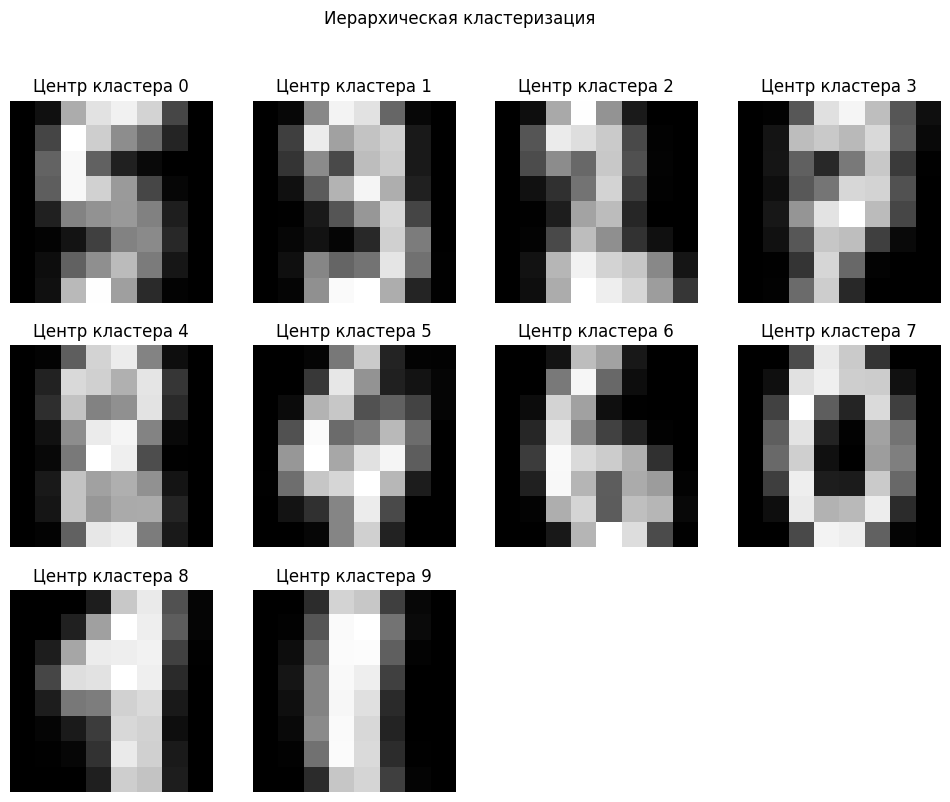

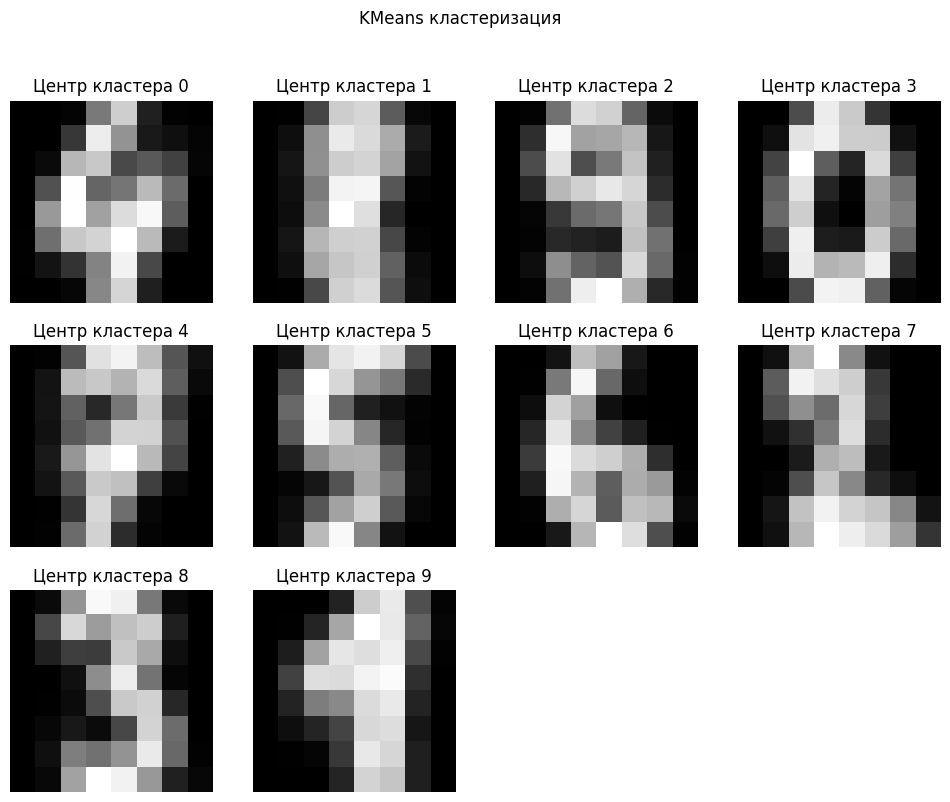

In [9]:
# Визуализация центров кластеров
def plot_cluster_centers(X, labels, title):
    unique_labels = np.unique(labels)
    
    plt.figure(figsize=(12, 9))
    
    for i, label in enumerate(unique_labels):
        mask = (labels == label)
        cluster_points = X[mask]
        cluster_center = np.mean(cluster_points, axis=0)
        
        plt.subplot(3, 4, i+1)
        plt.imshow(cluster_center.reshape(8, 8), cmap='gray', interpolation='nearest')
        plt.title(f'Центр кластера {label}')
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Визуализация для иерархической кластеризации
plot_cluster_centers(X, hierarchical_labels, 'Иерархическая кластеризация')

# Визуализация для KMeans
plot_cluster_centers(X, kmeans_labels, 'KMeans кластеризация')


На мой взгляд KMeans справился лучше,как я заметил в обоих случаях цифру 8 ,отображает просто как палку без каких либо разделений ,в поэтому несмотря на то что в иерахической кластеризации центр кластера 4 также похож на 8 я все же склонен думать это 3,а в обоих случаях палки это 8-рки

------------------------------------------------------------------------------------------------------------------

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M|} \sum_{x' \in M} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.


Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [10]:

for i in range(2,21):
    # Иерархическая кластеризация с явным указанием числа кластеров 
    hierarchical_clustering = AgglomerativeClustering(n_clusters=i)
    hierarchical_labels = hierarchical_clustering.fit_predict(X)

    # KMeans кластеризация с явным указанием числа кластеров 
    kmeans_clustering = KMeans(n_clusters=i, n_init=100)
    kmeans_labels = kmeans_clustering.fit_predict(X)
    # Вычислим метрику силуэта для оценки качества кластеризации
    silhouette_kmeans = silhouette_score(X, kmeans_labels)
    print(f"Значение метрики силуэта KMeans: {silhouette_kmeans} при числе кластеров:{i}")
    silhouette_hierarchical= silhouette_score(X, hierarchical_labels)
    print(f"Значение метрики силуэта иерархической кластеризации: {silhouette_hierarchical} при числе кластеров:{i}")

Значение метрики силуэта KMeans: 0.11832841100655983 при числе кластеров:2
Значение метрики силуэта иерархической кластеризации: 0.11674033985112256 при числе кластеров:2
Значение метрики силуэта KMeans: 0.12647646995440193 при числе кластеров:3
Значение метрики силуэта иерархической кластеризации: 0.11188954666963648 при числе кластеров:3
Значение метрики силуэта KMeans: 0.12803720509709254 при числе кластеров:4
Значение метрики силуэта иерархической кластеризации: 0.10895989445239453 при числе кластеров:4
Значение метрики силуэта KMeans: 0.1379244556230561 при числе кластеров:5
Значение метрики силуэта иерархической кластеризации: 0.11888125787404626 при числе кластеров:5
Значение метрики силуэта KMeans: 0.15147981197260985 при числе кластеров:6
Значение метрики силуэта иерархической кластеризации: 0.13701122727669246 при числе кластеров:6
Значение метрики силуэта KMeans: 0.16341725723769593 при числе кластеров:7
Значение метрики силуэта иерархической кластеризации: 0.153685710669489

Значение метрики силуэта KMeans: 0.18780044476490207 при числе кластеров:14   
Значение метрики силуэта иерархической кластеризации: 0.18061975703867697 при числе кластеров:9
Судя по значениям метрики мне кажется что это не очень продуктивно

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [11]:
from sklearn.metrics import homogeneity_completeness_v_measure

for i in range(2, 21):
    # Иерархическая кластеризация с явным указанием числа кластеров 
    hierarchical_clustering = AgglomerativeClustering(n_clusters=i)
    hierarchical_labels = hierarchical_clustering.fit_predict(X)

    # KMeans кластеризация с явным указанием числа кластеров 
    kmeans_clustering = KMeans(n_clusters=i, n_init=100)
    kmeans_labels = kmeans_clustering.fit_predict(X)
    
    # Вычисляем оценки однородности, полноты и V-меры
    hcv_scores_hierarchical = homogeneity_completeness_v_measure(y, hierarchical_labels)
    hcv_scores_kmeans = homogeneity_completeness_v_measure(y, kmeans_labels)
    
    # Выводим результаты

    print(f"hierarchical V-мера: {hcv_scores_hierarchical[2]} Число кластеров: {i}")
    print(f"KMeans V-мера: {hcv_scores_kmeans[2]} Число кластеров: {i}")


hierarchical V-мера: 0.40824218623422054 Число кластеров: 2
KMeans V-мера: 0.36001205373704537 Число кластеров: 2
hierarchical V-мера: 0.5440613747462535 Число кластеров: 3
KMeans V-мера: 0.4041226970761305 Число кластеров: 3
hierarchical V-мера: 0.6211638409365546 Число кластеров: 4
KMeans V-мера: 0.45867529091444553 Число кластеров: 4
hierarchical V-мера: 0.709653527412938 Число кластеров: 5
KMeans V-мера: 0.579317823548124 Число кластеров: 5
hierarchical V-мера: 0.7566664944734937 Число кластеров: 6
KMeans V-мера: 0.5959876786219793 Число кластеров: 6
hierarchical V-мера: 0.7983006479287973 Число кластеров: 7
KMeans V-мера: 0.6563877098088875 Число кластеров: 7
hierarchical V-мера: 0.8457771039270545 Число кластеров: 8
KMeans V-мера: 0.7155016228555755 Число кластеров: 8
hierarchical V-мера: 0.8446597933958961 Число кластеров: 9
KMeans V-мера: 0.7153362275055033 Число кластеров: 9
hierarchical V-мера: 0.8681701126909083 Число кластеров: 10
KMeans V-мера: 0.7418713895574987 Число кла

KMeans V-мера: 0.8383091399615094 Число кластеров: 17
KMeans V-мера: 0.7909709551992108 Число кластеров: 17
в данном случае число кластеров 17 вызвало самую большую V-меру

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

*<u>Замечание:</u>* Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [12]:
from sklearn.decomposition import TruncatedSVD

# Создаем экземпляр класса TruncatedSVD для различного числа оставляемых признаков
for n_components in [2, 5, 10, 20]:
    # Создаем объект TruncatedSVD
    svd = TruncatedSVD(n_components=n_components)
    
    # Применяем сингулярное разложение к матрице X
    X_reduced = svd.fit_transform(X)
    
    # Восстанавливаем матрицу X с уменьшенным числом признаков
    X_reconstructed = svd.inverse_transform(X_reduced)
    print(f"Размерность восстановленной матрицы с {n_components} признаками:", X_reconstructed.shape)
    
    # KMeans 
    kmeans_clustering = KMeans(n_clusters=10, n_init=100)
    kmeans_labels = kmeans_clustering.fit_predict(X_reconstructed)
    
    hcv_scores_kmeans = homogeneity_completeness_v_measure(y, kmeans_labels)
    
    # Выводим результаты

    
    print(f"KMeans V-мера: {hcv_scores_kmeans[2]}")

Размерность восстановленной матрицы с 2 признаками: (1797, 64)
KMeans V-мера: 0.34814173887857847
Размерность восстановленной матрицы с 5 признаками: (1797, 64)
KMeans V-мера: 0.6354531781617102
Размерность восстановленной матрицы с 10 признаками: (1797, 64)
KMeans V-мера: 0.7215689584759071
Размерность восстановленной матрицы с 20 признаками: (1797, 64)
KMeans V-мера: 0.7422729794392336


при размерности,востановленно матрицы 10 и 20 ,V-мера практически одинакова ,но у 20 на 0.0001 лучше

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.


Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

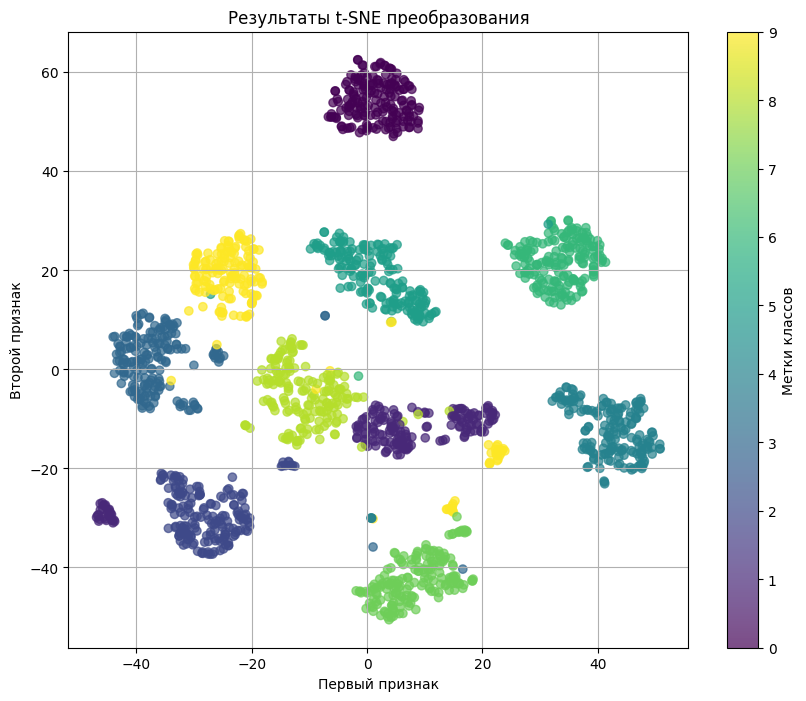

In [13]:
tsne = TSNE(n_components=2, random_state=42)  # Указываем желаемое количество компонент (2)

# Применяем t-SNE к исходным данным X
X_tsne = tsne.fit_transform(X)

# Визуализируем данные
plt.figure(figsize=(10, 8))

# Разные цифры будут иметь разные цвета на графике
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)

plt.title('Результаты t-SNE преобразования')
plt.xlabel('Первый признак')
plt.ylabel('Второй признак')
plt.colorbar(label='Метки классов')
plt.grid(True)
plt.show()



Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [14]:
kmeans_clustering = KMeans(n_clusters=10, n_init=100)
kmeans_labels_X_tsne = kmeans_clustering.fit_predict(X_tsne)
hcv_scores_kmeans_tsne = homogeneity_completeness_v_measure(y, kmeans_labels_X_tsne)
print(f"KMeans V-мера после t-SNE: {hcv_scores_kmeans_tsne[2]}")
silhouette_kmeans_tsne = silhouette_score(X_tsne, kmeans_labels_X_tsne)
print(f"Значение метрики силуэта KMeans: {silhouette_kmeans_tsne}")

KMeans V-мера после t-SNE: 0.912284291343296
Значение метрики силуэта KMeans: 0.6419783234596252


Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

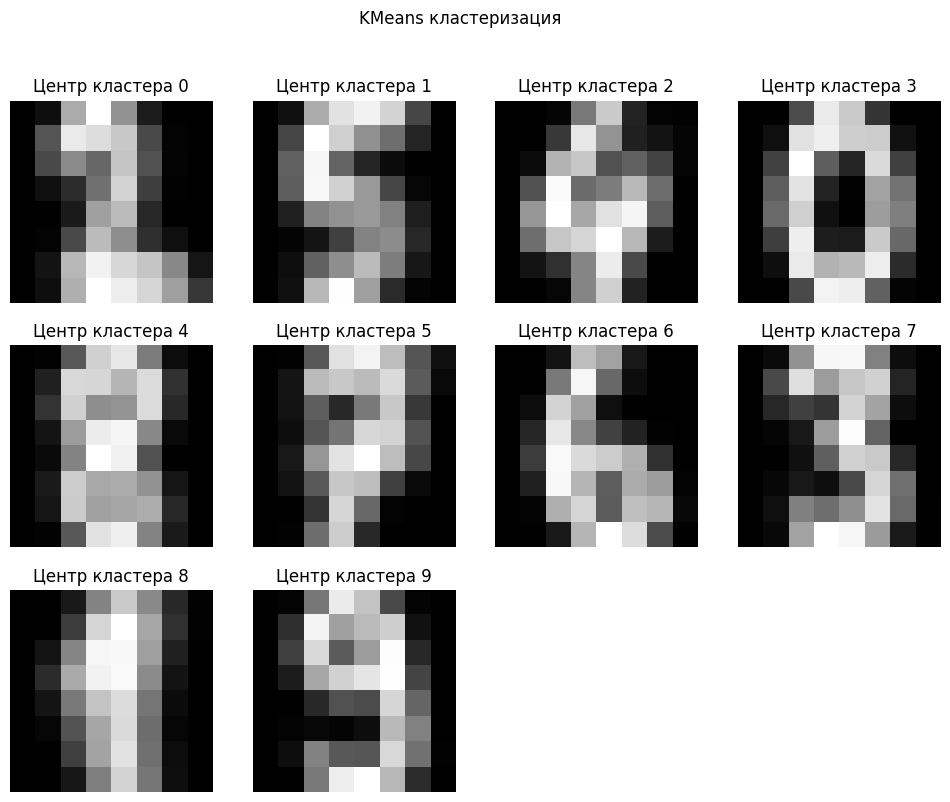

In [15]:
# Визуализация центров кластеров
def plot_cluster_centers(X, labels, title):
    unique_labels = np.unique(labels)
    
    plt.figure(figsize=(12, 9))
    
    for i, label in enumerate(unique_labels):
        mask = (labels == label)
        cluster_points = X[mask]
        cluster_center = np.mean(cluster_points, axis=0)
        
        plt.subplot(3, 4, i+1)
        plt.imshow(cluster_center.reshape(8, 8), cmap='gray', interpolation='nearest')
        plt.title(f'Центр кластера {label}')
        plt.axis('off')

    plt.suptitle(title)
    plt.show()


# Визуализация для KMeans
plot_cluster_centers(X, kmeans_labels_X_tsne, 'KMeans кластеризация')

в данном случае каждый кластер это отдельная цифра с четко видными для нее особенностями

# 4. Итоги

Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

На мой взгляд самое удачное сочетние это исмпользование K-means + tSNE + метрики V-меры.K-средних давал боее осмысленные кластеры с учетом использования настроек ,а также использование V-меры давало большихх реузльтат метрик.При уменьшении размрности признакового пространства значительно улучшается качество кластеризации

Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

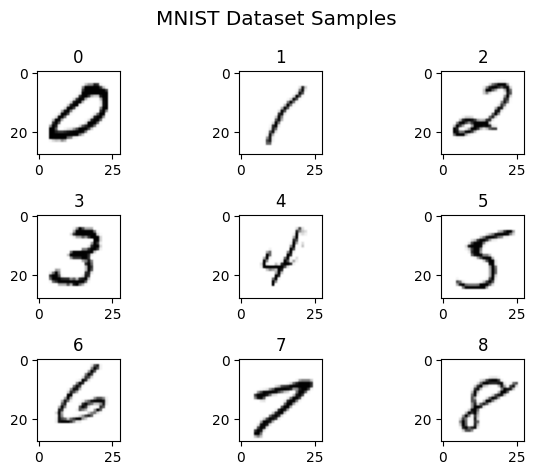

In [16]:

import tensorflow
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from sklearn.manifold import SpectralEmbedding# Load the MNIST data set
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

# Plot some sample images from data set
plt.figure()
plt.suptitle("MNIST Dataset Samples", fontsize = 'x-large')
label_indexes = { training_labels[i]: i for i in range(len(training_labels)) }

for i in range(9):
    index = label_indexes[i]
    plt.subplot(3, 3, i + 1)
    plt.title(training_labels[index])
    plt.imshow(training_images[index].reshape(28, 28), cmap = 'Greys')
    
plt.tight_layout()

Я не смог зайти на датасет по инструкции,так как в одном месте требует пароль,в другом ошибка 404,но на сайте tensorwlow я нашел данный датасет и код по его загрузке откуда я  его благополучно скопировал

In [17]:
# При работе с данным датасетом у меня появилась проблема размерности где все методы что я пытался применить работали только с двойной размерность,в итоге я принял волевое решение понизить ее до двух таким образом что мне помогло
num_samples = len(training_images)
num_features = 28 * 28
training_images_flat = training_images.reshape(num_samples, num_features)

# Теперь training_images_flat содержит данные в форме (num_samples, num_features),
# где num_samples - количество образцов, а num_features - количество признаков для каждого образца

In [18]:

tsne = TSNE(n_components=2, random_state=42)  # Указываем желаемое количество компонент (2)

# Создаем объект PCA 
"""pca = PCA(n_components=2)
# Применяем PCA к исходным данным X
training_images_pca = pca.fit_transform(training_images_flat)""" #В случае использования еще и PCA V-мера дает около 0.32

# Применяем t-SNE к исходным данным training_images_flat
training_images_tsne = tsne.fit_transform(training_images_flat)

kmeans_clustering = KMeans(n_clusters=10, n_init=100)
kmeans_labels_training_images_tsne = kmeans_clustering.fit_predict(training_images_tsne)

hcv_scores_kmeans_tsne = homogeneity_completeness_v_measure(training_labels, kmeans_labels_training_images_tsne)
print(f"KMeans V-мера после t-SNE: {hcv_scores_kmeans_tsne[2]}")

'\n# Применяем t-SNE к исходным данным X\ntraining_images_tsne = tsne.fit_transform(training_images_flat)\n\nkmeans_clustering = KMeans(n_clusters=10, n_init=100)\nkmeans_labels_training_images_tsne = kmeans_clustering.fit_predict(training_images_tsne)\n\nhcv_scores_kmeans_tsne = homogeneity_completeness_v_measure(training_labels, kmeans_labels_training_images_tsne)\nprint(f"KMeans V-мера после t-SNE: {hcv_scores_kmeans_tsne[2]}")'

In [19]:

from sklearn.decomposition import TruncatedSVD

# Создаем экземпляр класса TruncatedSVD для различного числа оставляемых признаков
for n_components in [20]:
    # Создаем объект TruncatedSVD
    svd = TruncatedSVD(n_components=n_components)
    
    # Применяем сингулярное разложение к матрице X
    X_reduced = svd.fit_transform(training_images_flat)
    
    # Восстанавливаем матрицу X с уменьшенным числом признаков
    X_reconstructed = svd.inverse_transform(X_reduced)
    print(f"Размерность восстановленной матрицы с {n_components} признаками:", X_reconstructed.shape)
    
    # KMeans 
    kmeans_clustering = KMeans(n_clusters=10, n_init=100)
    kmeans_labels = kmeans_clustering.fit_predict(X_reconstructed)
    
    hcv_scores_kmeans = homogeneity_completeness_v_measure(training_labels, kmeans_labels)
    
    # Выводим результаты

    
    print(f"KMeans V-мера: {hcv_scores_kmeans[2]}")

Размерность восстановленной матрицы с 20 признаками: (60000, 784)
KMeans V-мера: 0.4875561812328137


Размерность восстановленной матрицы с 20 признаками: (60000, 784)
KMeans V-мера: 0.4875561812328137 
что намного ниже чем у tSNE

пока что на данный момент использование tNSE дает самый лучший результат ,но мне нужно технически обслужить ноубук так что я пока чзалью первую версию свое задания без всех комментариев и без аналза сингулярного разложения так как мой комп почему то просто вырубется после попытки его просчитать